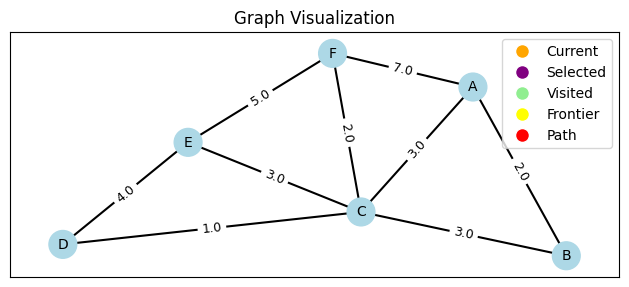

In [36]:
import tkinter as tk
from tkinter import messagebox, scrolledtext, ttk
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import time
from collections import deque
import heapq
import math

# -------------------------
# Globals and helpers
# -------------------------
G = nx.Graph()
pos = {}                  
step_generator = None
playing = False
play_delay_ms = 500
after_id = None

# UI references (set later)
graph_frame = None
info_text = None
canvas_widget = None
table_frame = None
table_tree = None
node_show_distances = True  

# Interactive features
selected_node = None
dragging = False
mouse_pos = (0, 0)

# -------------------------
# GUI / Graph creation
# -------------------------
def create_graph():
    global G, pos, step_generator, playing
    # Stop any running visualization
    stop_playback()

    G.clear()
    pos.clear()

    nodes_input = nodes_entry.get().strip()
    edges_input = edges_entry.get().strip()

    nodes = [n.strip() for n in nodes_input.split(",") if n.strip()]
    if not nodes:
        messagebox.showerror("Input Error", "Please enter at least one node.")
        return
    G.add_nodes_from(nodes)

    # Parse edges in format A-B-4 (comma separated)
    edges = []
    if edges_input:
        for edge_str in edges_input.split(","):
            edge_str = edge_str.strip()
            if not edge_str:
                continue
            try:
                u, v, w = edge_str.split("-")
                edges.append((u.strip(), v.strip(), float(w.strip())))
            except Exception as e:
                messagebox.showerror("Input Error", f"Invalid edge format: {edge_str}\nUse format: A-B-4")
                return
    G.add_weighted_edges_from(edges)

    # fixed layout so nodes don't jump between steps
    try:
        pos = nx.spring_layout(G, seed=42)
    except Exception:
        pos = nx.circular_layout(G)

    # update start/end menus
    update_menus(nodes)
    draw_graph()  # draw initial graph
    clear_table()

def update_menus(nodes):
    menu = start_menu["menu"]
    menu.delete(0, "end")
    for node in nodes:
        menu.add_command(label=node, command=lambda value=node: start_var.set(value))

    menu = end_menu["menu"]
    menu.delete(0, "end")
    for node in nodes:
        menu.add_command(label=node, command=lambda value=node: end_var.set(value))

# -------------------------
# Interactive features
# -------------------------
def on_node_click(event):
    """Handle node clicking for interactive features"""
    global selected_node
    if not pos:
        return
    
    # Convert canvas coordinates to data coordinates
    canvas = event.widget
    x_click = canvas.canvasx(event.x)
    y_click = canvas.canvasy(event.y)
    
    # Find closest node (simplified - would need proper coordinate transformation)
    min_dist = float('inf')
    closest_node = None
    
    for node in G.nodes():
        # This is a simplified approach - in a real implementation you'd need
        # to properly convert between matplotlib and tkinter coordinates
        node_x, node_y = pos[node]
        dist = ((x_click/100 - node_x)**2 + (y_click/100 - node_y)**2)**0.5
        if dist < min_dist:
            min_dist = dist
            closest_node = node
    
    if min_dist < 0.2:  # threshold for selection
        if event.num == 1:  # Left click - select node
            selected_node = closest_node
            write_log(f"Selected node: {closest_node}")
            # Update start/end dropdowns
            if event.state & 0x1:  # Shift key held
                end_var.set(closest_node)
                write_log(f"Set end node to: {closest_node}")
            else:
                start_var.set(closest_node)
                write_log(f"Set start node to: {closest_node}")
            draw_graph()

def add_node():
    """Add a new node to the graph"""
    new_node = new_node_entry.get().strip()
    if not new_node:
        messagebox.showwarning("Warning", "Please enter a node name.")
        return
    
    if new_node in G.nodes():
        messagebox.showwarning("Warning", f"Node {new_node} already exists.")
        return
    
    G.add_node(new_node)
    # Add to a random position
    import random
    pos[new_node] = (random.uniform(-1, 1), random.uniform(-1, 1))
    
    update_menus(list(G.nodes()))
    draw_graph()
    new_node_entry.delete(0, tk.END)
    write_log(f"Added node: {new_node}")

def add_edge():
    """Add a new edge to the graph"""
    try:
        edge_str = new_edge_entry.get().strip()
        u, v, w = edge_str.split("-")
        u, v, w = u.strip(), v.strip(), float(w.strip())
        
        if u not in G.nodes() or v not in G.nodes():
            messagebox.showerror("Error", "Both nodes must exist in the graph.")
            return
        
        G.add_edge(u, v, weight=w)
        draw_graph()
        new_edge_entry.delete(0, tk.END)
        write_log(f"Added edge: {u}-{v} (weight: {w})")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid edge format. Use: A-B-4")

def remove_selected():
    """Remove selected node or edge"""
    global selected_node
    if selected_node and selected_node in G.nodes():
        G.remove_node(selected_node)
        if selected_node in pos:
            del pos[selected_node]
        update_menus(list(G.nodes()))
        draw_graph()
        write_log(f"Removed node: {selected_node}")
        selected_node = None

# -------------------------
# Enhanced Table management for all algorithms
# -------------------------
def setup_table():
    """Initialize the algorithm table"""
    global table_tree
    if table_tree:
        table_tree.destroy()
    
    table_tree = ttk.Treeview(table_frame)
    table_tree.pack(fill="both", expand=True)

def update_bfs_table(state):
    """Update the table for BFS algorithm"""
    if not table_tree or state.get("algorithm") != "BFS":
        return
    
    visited = state.get("visited", set())
    frontier = state.get("frontier", [])
    current = state.get("current")
    parents = state.get("parents", {})
    
    # Clear existing items
    for item in table_tree.get_children():
        table_tree.delete(item)
    
    # Setup columns for BFS
    table_tree["columns"] = ("Node", "Status", "Parent", "Queue_Position")
    table_tree["show"] = "headings"
    
    for col in table_tree["columns"]:
        table_tree.heading(col, text=col.replace("_", " "))
        table_tree.column(col, width=100)
    
    # Add data rows
    for node in sorted(G.nodes()):
        parent_str = parents.get(node, "None") or "None"
        
        if node == current:
            status = "Current"
            tags = ("current",)
        elif node in visited:
            status = "Visited"
            tags = ("visited",)
        elif node in frontier:
            status = "In Queue"
            tags = ("frontier",)
        else:
            status = "Unvisited"
            tags = ("unvisited",)
        
        # Queue position
        queue_pos = ""
        if node in frontier:
            try:
                queue_pos = str(frontier.index(node) + 1)
            except ValueError:
                queue_pos = "N/A"
        
        table_tree.insert("", "end", values=(node, status, parent_str, queue_pos), tags=tags)
    
    # Show current queue state
    if frontier:
        queue_str = " → ".join(frontier)
        table_tree.insert("", "end", values=("QUEUE:", queue_str, "", ""), tags=("queue_info",))
    
    # Configure tag colors
    table_tree.tag_configure("current", background="orange")
    table_tree.tag_configure("visited", background="lightgreen")
    table_tree.tag_configure("frontier", background="yellow")
    table_tree.tag_configure("unvisited", background="lightblue")
    table_tree.tag_configure("queue_info", background="lightcyan", font=("Arial", 9, "bold"))

def update_dijkstra_table(state):
    """Update the distance table for Dijkstra's algorithm"""
    if not table_tree or state.get("algorithm") != "Dijkstra":
        return
    
    distances = state.get("distances", {})
    parents = state.get("parents", {})
    visited = state.get("visited", set())
    current = state.get("current")
    frontier = state.get("frontier", [])
    
    # Clear existing items
    for item in table_tree.get_children():
        table_tree.delete(item)
    
    # Setup columns
    table_tree["columns"] = ("Node", "Distance", "Previous", "Status", "Priority_Queue")
    table_tree["show"] = "headings"
    
    for col in table_tree["columns"]:
        table_tree.heading(col, text=col.replace("_", " "))
        table_tree.column(col, width=90)
    
    # Add data rows
    for node in sorted(G.nodes()):
        dist_str = "∞" if distances.get(node, math.inf) == math.inf else f"{distances[node]:.1f}"
        prev_str = parents.get(node, "None") or "None"
        
        if node == current:
            status = "Current"
            tags = ("current",)
        elif node in visited:
            status = "Visited"
            tags = ("visited",)
        elif node in frontier:
            status = "In PQ"
            tags = ("frontier",)
        else:
            status = "Unvisited"
            tags = ("unvisited",)
        
        pq_status = "Yes" if node in frontier else "No"
        
        table_tree.insert("", "end", values=(node, dist_str, prev_str, status, pq_status), tags=tags)
    
    # Show current priority queue
    if frontier:
        pq_str = ", ".join(frontier)
        table_tree.insert("", "end", values=("PQ:", pq_str, "", "", ""), tags=("queue_info",))
    
    # Configure tag colors
    table_tree.tag_configure("current", background="orange")
    table_tree.tag_configure("visited", background="lightgreen")
    table_tree.tag_configure("frontier", background="yellow")
    table_tree.tag_configure("unvisited", background="lightblue")
    table_tree.tag_configure("queue_info", background="lightcyan", font=("Arial", 9, "bold"))

def update_bellman_ford_table(state):
    """Update the table for Bellman-Ford algorithm"""
    if not table_tree or state.get("algorithm") != "Bellman-Ford":
        return
    
    distances = state.get("distances", {})
    parents = state.get("parents", {})
    iteration = state.get("iteration", 0)
    edge = state.get("edge", None)
    
    # Clear existing items
    for item in table_tree.get_children():
        table_tree.delete(item)
    
    # Setup columns
    table_tree["columns"] = ("Node", "Distance", "Previous", "Last_Updated")
    table_tree["show"] = "headings"
    
    for col in table_tree["columns"]:
        table_tree.heading(col, text=col.replace("_", " "))
        table_tree.column(col, width=100)
    
    # Add iteration info
    table_tree.insert("", "end", values=(f"Iteration {iteration}", "", "", ""), tags=("iteration_info",))
    
    # Add data rows
    for node in sorted(G.nodes()):
        dist_str = "∞" if distances.get(node, math.inf) == math.inf else f"{distances[node]:.1f}"
        prev_str = parents.get(node, "None") or "None"
        
        # Check if this node was just updated
        if edge and edge[1] == node:
            tags = ("updated",)
            last_updated = f"Iter {iteration}"
        else:
            tags = ("normal",)
            last_updated = ""
        
        table_tree.insert("", "end", values=(node, dist_str, prev_str, last_updated), tags=tags)
    
    # Show current edge being processed
    if edge:
        edge_str = f"{edge[0]} → {edge[1]} (w={state.get('edge_weight', '?')})"
        table_tree.insert("", "end", values=("Processing:", edge_str, "", ""), tags=("edge_info",))
    
    # Configure tag colors
    table_tree.tag_configure("iteration_info", background="lightcyan", font=("Arial", 9, "bold"))
    table_tree.tag_configure("updated", background="orange")
    table_tree.tag_configure("normal", background="lightblue")
    table_tree.tag_configure("edge_info", background="lightyellow", font=("Arial", 9, "bold"))

def update_floyd_warshall_table(state):
    """Update the table for Floyd-Warshall algorithm"""
    if not table_tree or state.get("algorithm") != "Floyd-Warshall":
        return
    
    distances = state.get("distances", {})
    k = state.get("k", None)
    i = state.get("i", None)
    j = state.get("j", None)
    
    # Clear existing items
    for item in table_tree.get_children():
        table_tree.delete(item)
    
    # Setup columns - show distance matrix
    nodes = sorted(G.nodes())
    columns = ["From/To"] + nodes
    table_tree["columns"] = columns
    table_tree["show"] = "headings"
    
    for col in columns:
        table_tree.heading(col, text=col)
        table_tree.column(col, width=60)
    
    # Add current k value info
    if k is not None:
        k_info = f"Via node: {k}"
        if i is not None and j is not None:
            k_info += f" | Updating: {i}→{j}"
        table_tree.insert("", "end", values=([k_info] + [""] * len(nodes)), tags=("k_info",))
    
    # Add distance matrix rows
    for from_node in nodes:
        row_values = [from_node]
        for to_node in nodes:
            if from_node in distances and to_node in distances[from_node]:
                dist = distances[from_node][to_node]
                if dist == math.inf:
                    row_values.append("∞")
                else:
                    row_values.append(f"{dist:.1f}")
            else:
                row_values.append("∞")
        
        # Highlight the row being updated
        if i == from_node and j is not None:
            tags = ("updated",)
        else:
            tags = ("normal",)
        
        table_tree.insert("", "end", values=row_values, tags=tags)
    
    # Configure tag colors
    table_tree.tag_configure("k_info", background="lightcyan", font=("Arial", 9, "bold"))
    table_tree.tag_configure("updated", background="orange")
    table_tree.tag_configure("normal", background="lightblue")

def clear_table():
    """Clear the algorithm table"""
    if table_tree:
        for item in table_tree.get_children():
            table_tree.delete(item)

# -------------------------
# Algorithm generators (yield state dicts)
# -------------------------
def bfs_steps(graph, start, end):
    """Yield states as BFS explores the graph."""
    visited = set([start])
    parent = {start: None}
    queue = deque([start])

    yield {"phase": "start", "algorithm": "BFS",
           "visited": set(), "frontier": list(queue), "parents": dict(parent), "distances": None, "current": None,
           "log": f"Start BFS from {start} looking for {end}"}

    while queue:
        current = queue.popleft()
        yield {"phase": "visit", "algorithm": "BFS",
               "current": current, "visited": set(visited), "frontier": list(queue),
               "parents": dict(parent), "distances": None,
               "edge": None, "log": f"Popped {current} from queue. Queue now: {list(queue)}"}

        if current == end:
            # reconstruct path
            path = []
            node = end
            while node is not None:
                path.append(node)
                node = parent.get(node)
            path.reverse()
            yield {"phase": "found", "algorithm": "BFS", "current": current,
                   "visited": set(visited), "frontier": list(queue), "parents": dict(parent),
                   "distances": None, "path": path, "log": f"Target {end} found. Path: {path}"}
            return

        for nbr in graph.neighbors(current):
            if nbr not in visited:
                visited.add(nbr)
                parent[nbr] = current
                queue.append(nbr)
                yield {"phase": "enqueue", "algorithm": "BFS",
                       "current": current, "visited": set(visited), "frontier": list(queue),
                       "parents": dict(parent), "distances": None,
                       "edge": (current, nbr), "log": f"Discovered {nbr} from {current}, added to queue. Queue: {list(queue)}"}

    yield {"phase": "end", "algorithm": "BFS", "log": "BFS finished: no path found."}
    return

def dijkstra_steps(graph, start, end):
    dist = {n: math.inf for n in graph.nodes()}
    parent = {n: None for n in graph.nodes()}
    dist[start] = 0
    pq = [(0, start)]
    visited = set()

    yield {"phase": "start", "algorithm": "Dijkstra", "distances": dict(dist),
           "parents": dict(parent), "visited": set(), "frontier": [start], 
           "log": f"Start Dijkstra from {start}. Initialize distances."}

    while pq:
        d, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        frontier_nodes = [p for _, p in pq]
        yield {"phase": "pop", "algorithm": "Dijkstra", "current": u, "distances": dict(dist),
               "parents": dict(parent), "visited": set(visited), "frontier": frontier_nodes,
               "log": f"Popped {u} with distance {d} from priority queue."}

        if u == end:
            # reconstruct path
            path = []
            node = end
            while node is not None:
                path.append(node)
                node = parent.get(node)
            path.reverse()
            yield {"phase": "found", "algorithm": "Dijkstra", "path": path, "distances": dict(dist),
                   "parents": dict(parent), "visited": set(visited), 
                   "log": f"Target {end} reached with distance {dist[end]}. Path: {path}"}
            return

        for v in graph.neighbors(u):
            w = graph[u][v].get("weight", 1)
            if dist[u] + w < dist[v]:
                old = dist[v]
                dist[v] = dist[u] + w
                parent[v] = u
                heapq.heappush(pq, (dist[v], v))
                frontier_nodes = [p for _, p in pq]
                yield {"phase": "relax", "algorithm": "Dijkstra", "current": u, "edge": (u, v), "edge_weight": w,
                       "old_distance": old, "new_distance": dist[v], "distances": dict(dist),
                       "parents": dict(parent), "visited": set(visited),
                       "frontier": frontier_nodes, "log": f"Relaxed edge {u}→{v} (w={w}): distance {old} → {dist[v]}"}

    yield {"phase": "end", "algorithm": "Dijkstra", "log": "Dijkstra finished: no path found."}
    return

def bellman_ford_steps(graph, start, end):
    nodes = list(graph.nodes())
    dist = {n: math.inf for n in nodes}
    parent = {n: None for n in nodes}
    dist[start] = 0

    edges = []
    for u, v, data in graph.edges(data=True):
        w = data.get("weight", 1)
        edges.append((u, v, w))
        # for undirected graph we also can consider v->u
        if isinstance(graph, nx.Graph):
            edges.append((v, u, w))

    yield {"phase": "start", "algorithm": "Bellman-Ford", "distances": dict(dist),
           "parents": dict(parent), "iteration": 0, 
           "log": f"Start Bellman-Ford from {start}. Initialize distances."}

    n = len(nodes)
    for i in range(n - 1):
        any_update = False
        yield {"phase": "iteration_start", "algorithm": "Bellman-Ford", "iteration": i + 1,
               "distances": dict(dist), "parents": dict(parent), 
               "log": f"Starting iteration {i+1}/{n-1}"}
        
        for (u, v, w) in edges:
            if dist[u] != math.inf and dist[u] + w < dist[v]:
                old = dist[v]
                dist[v] = dist[u] + w
                parent[v] = u
                any_update = True
                yield {"phase": "relax", "algorithm": "Bellman-Ford", "iteration": i + 1,
                       "edge": (u, v), "edge_weight": w, "old_distance": old, "new_distance": dist[v],
                       "distances": dict(dist), "parents": dict(parent),
                       "log": f"Relaxed {u}→{v} (w={w}): {old} → {dist[v]}"}
        
        if not any_update:
            yield {"phase": "converged", "algorithm": "Bellman-Ford", "iteration": i + 1,
                   "distances": dict(dist), "parents": dict(parent), 
                   "log": f"Converged at iteration {i+1} - no more updates possible."}
            break

    # final path if reachable
    if dist[end] != math.inf:
        path = []
        node = end
        while node is not None:
            path.append(node)
            node = parent.get(node)
        path.reverse()
        yield {"phase": "found", "algorithm": "Bellman-Ford", "path": path, "distances": dict(dist),
               "parents": dict(parent), "log": f"Path found with distance {dist[end]}: {path}"}
    else:
        yield {"phase": "end", "algorithm": "Bellman-Ford", "log": "No path found by Bellman-Ford."}
    return

def floyd_warshall_steps(graph, start, end):
    nodes = list(graph.nodes())
    # initialize distance and next matrix
    dist = {i: {j: math.inf for j in nodes} for i in nodes}
    next_node = {i: {j: None for j in nodes} for i in nodes}
    for n in nodes:
        dist[n][n] = 0
        next_node[n][n] = n
    for u, v, data in graph.edges(data=True):
        w = data.get("weight", 1)
        dist[u][v] = min(dist[u][v], w)
        next_node[u][v] = v
        # for undirected graphs
        if isinstance(graph, nx.Graph):
            dist[v][u] = min(dist[v][u], w)
            next_node[v][u] = u

    yield {"phase": "start", "algorithm": "Floyd-Warshall",
           "distances": {x: dict(dist[x]) for x in nodes}, "next": next_node, 
           "log": "Start Floyd-Warshall. Initialize distance matrix."}

    for k in nodes:
        yield {"phase": "k_start", "algorithm": "Floyd-Warshall", "k": k,
               "distances": {x: dict(dist[x]) for x in nodes}, 
               "log": f"Processing intermediate node k = {k}"}
        
        for i in nodes:
            for j in nodes:
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    old = dist[i][j]
                    dist[i][j] = dist[i][k] + dist[k][j]
                    next_node[i][j] = next_node[i][k]
                    yield {"phase": "update", "algorithm": "Floyd-Warshall",
                           "k": k, "i": i, "j": j, "old": old, "new": dist[i][j],
                           "distances": {x: dict(dist[x]) for x in nodes}, "next": next_node,
                           "log": f"Updated dist[{i}][{j}] via {k}: {old:.1f if old != math.inf else '∞'} → {dist[i][j]:.1f}"}
        
        yield {"phase": "iteration_end", "algorithm": "Floyd-Warshall", "k": k,
               "distances": {x: dict(dist[x]) for x in nodes}, 
               "log": f"Completed processing k = {k}"}

    # reconstruct path between start and end if exists
    if next_node[start][end] is not None and dist[start][end] < math.inf:
        path = [start]
        u = start
        while u != end:
            u = next_node[u][end]
            if u is None:
                break
            path.append(u)
        yield {"phase": "found", "algorithm": "Floyd-Warshall", "path": path,
               "distances": {x: dict(dist[x]) for x in nodes}, 
               "log": f"Path {start}→{end} found with distance {dist[start][end]}: {path}"}
    else:
        yield {"phase": "end", "algorithm": "Floyd-Warshall", 
               "log": f"No path exists from {start} to {end}."}
    return

# -------------------------
# Visualization / drawing
# -------------------------
def draw_graph(state=None):
    """Draw graph using current G and optional state to color/highlight nodes & edges."""
    global canvas_widget, graph_frame, pos, selected_node

    for widget in graph_frame.winfo_children():
        widget.destroy()

    fig, ax = plt.subplots(figsize=(8, 6))

    # Show algorithm name and (optionally) time complexity in title
    title = "Graph Visualization"
    if state and "algorithm" in state:
        algo = state["algorithm"]
        title = f"{algo} Visualization"
        # Add time complexity below title
        complexity = get_time_complexity(algo)
        if complexity:
            title += f"\nTime Complexity: {complexity}"

    ax.set_title(title)

    # defaults
    node_colors = []
    node_sizes = []
    labels = {}
    edge_colors = []
    edge_widths = []

    # determine style based on state
    visited = set()
    frontier = []
    current = None
    path = None
    edge_being_considered = None
    distances = None
    if state:
        visited = set(state.get("visited", []))
        frontier = list(state.get("frontier", []))
        current = state.get("current", None)
        path = state.get("path", None)
        edge_being_considered = state.get("edge", None)
        distances = state.get("distances", None)

    for n in G.nodes():
        # base color:
        if n == current:
            node_colors.append("orange")
            node_sizes.append(800)
        elif n == selected_node:
            node_colors.append("purple")
            node_sizes.append(700)
        elif path and n in (path):
            node_colors.append("red")
            node_sizes.append(600)
        elif n in visited:
            node_colors.append("lightgreen")
            node_sizes.append(500)
        elif n in frontier:
            node_colors.append("yellow")
            node_sizes.append(500)
        else:
            node_colors.append("lightblue")
            node_sizes.append(400)

        # node label shows name and (optionally) distance
        label = n
        if distances and n in distances:
            d = distances[n]
            if d == math.inf:
                label = f"{n}\n∞"
            else:
                label = f"{n}\n{d:.1f}"
        labels[n] = label

    # edges
    for u, v, data in G.edges(data=True):
        if path and (u, v) in zip(path, path[1:]) or path and (v, u) in zip(path, path[1:]):
            edge_colors.append("red")
            edge_widths.append(4.0)
            continue
        if edge_being_considered and ((u == edge_being_considered[0] and v == edge_being_considered[1]) or
                                      (u == edge_being_considered[1] and v == edge_being_considered[0])):
            edge_colors.append("orange")
            edge_widths.append(3.0)
            continue
        edge_colors.append("black")
        edge_widths.append(1.5)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, width=edge_widths)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, ax=ax)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Current'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Selected'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='Visited'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Frontier'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Path')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

    canvas = FigureCanvasTkAgg(fig, master=graph_frame)
    canvas_widget_local = canvas.get_tk_widget()
    canvas_widget_local.pack(fill="both", expand=True)
    canvas.draw()

    # Bind mouse events for interactivity
    canvas_widget_local.bind("<Button-1>", on_node_click)

    # keep reference
    canvas_widget = canvas

def write_log(line):
    """Append a line to info/log text widget (scrolledtext)."""
    global info_text
    if info_text:
        info_text.configure(state="normal")
        info_text.insert(tk.END, line + "\n")
        info_text.see(tk.END)
        info_text.configure(state="disabled")

def clear_log():
    if info_text:
        info_text.configure(state="normal")
        info_text.delete("1.0", tk.END)
        info_text.configure(state="disabled")

# -------------------------
# Playback control
# -------------------------
def start_visualization(algorithm):
    global step_generator, playing
    stop_playback()   # reset previous
    clear_log()
    setup_table()  # Initialize table for this algorithm
    
    # show algorithm description + complexity
    info = algorithm_info(algorithm)
    write_log(info)
    write_log("------")
    
    # create generator
    start_node = start_var.get()
    end_node = end_var.get()
    if not start_node or not end_node:
        messagebox.showwarning("Warning", "Please select start and end nodes.")
        return

    if start_node not in G.nodes() or end_node not in G.nodes():
        messagebox.showerror("Error", "Start/End nodes must be in graph.")
        return

    if algorithm == "BFS":
        step_generator = bfs_steps(G, start_node, end_node)
    elif algorithm == "Dijkstra":
        step_generator = dijkstra_steps(G, start_node, end_node)
    elif algorithm == "Bellman-Ford":
        step_generator = bellman_ford_steps(G, start_node, end_node)
    elif algorithm == "Floyd-Warshall":
        step_generator = floyd_warshall_steps(G, start_node, end_node)
    else:
        messagebox.showerror("Error", "Unknown algorithm.")
        return

    # show first state immediately
    step_next()

def step_next():
    """Advance one step in the generator and render."""
    global step_generator, playing, after_id
    if step_generator is None:
        write_log("No active visualization. Press an algorithm button to start.")
        return
    try:
        state = next(step_generator)
        # log the state message if present
        log = state.get("log")
        if log:
            write_log(log)

        # draw graph according to state
        draw_graph(state)
        
        # Update appropriate table based on algorithm
        algorithm = state.get("algorithm")
        if algorithm == "BFS":
            update_bfs_table(state)
        elif algorithm == "Dijkstra":
            update_dijkstra_table(state)
        elif algorithm == "Bellman-Ford":
            update_bellman_ford_table(state)
        elif algorithm == "Floyd-Warshall":
            update_floyd_warshall_table(state)

        # if generator finished in this step, stop playing
        if state.get("phase") in ("found", "end", "converged"):
            playing = False
            return

        if playing:
            after_id = root.after(play_delay_ms, step_next)
    except StopIteration:
        playing = False
        write_log("Visualization finished.")

def play_pause_toggle():
    global playing, after_id
    if playing:
        playing = False
        if after_id:
            root.after_cancel(after_id)
        write_log("Paused visualization")
    else:
        playing = True
        write_log("Resumed visualization")
        step_next()

def stop_playback():
    global playing, step_generator, after_id
    playing = False
    step_generator = None
    if after_id:
        root.after_cancel(after_id)
        after_id = None

def set_speed(val):
    global play_delay_ms
    play_delay_ms = int(val)

# -------------------------
# Info functions
# -------------------------
def algorithm_info(name):
    infos = {
        "BFS": (
            "BFS (Breadth-First Search): finds shortest path in unweighted graphs.\n"
            "Explores level by level, using a queue (FIFO).\n"
            "Time Complexity: O(V + E)\n"
            "Space Complexity: O(V)"
        ),
        "Dijkstra": (
            "Dijkstra: single-source shortest path for non-negative edge weights.\n"
            "Uses a priority queue to greedily pick the closest unvisited node.\n"
            "Time Complexity: O((V + E) log V)\n"
            "Space Complexity: O(V)"
        ),
        "Bellman-Ford": (
            "Bellman-Ford: single-source algorithm that supports negative weights.\n"
            "Performs repeated relaxations over all edges (|V|-1 iterations).\n"
            "Time Complexity: O(V × E)\n"
            "Space Complexity: O(V)"
        ),
        "Floyd-Warshall": (
            "Floyd-Warshall: all-pairs shortest paths algorithm.\n"
            "Dynamic programming over intermediate nodes k; updates distance matrix.\n"
            "Time Complexity: O(V³)\n"
            "Space Complexity: O(V²)"
        )
    }
    return infos.get(name, "No information available.")

def get_time_complexity(name):
    complexities = {
        "BFS": "O(V + E)",
        "Dijkstra": "O((V + E) log V)",
        "Bellman-Ford": "O(V × E)",
        "Floyd-Warshall": "O(V³)"
    }
    return complexities.get(name, "")

# -------------------------
# Build GUI
# -------------------------
root = tk.Tk()
root.title("Enhanced Interactive Pathfinding Algorithm Visualizer")
root.geometry("1400x800")

# Create main container with paned window
main_paned = tk.PanedWindow(root, orient=tk.HORIZONTAL)
main_paned.pack(fill=tk.BOTH, expand=True, padx=5, pady=5)

# Left panel for controls and graph
left_panel = tk.Frame(main_paned)
main_paned.add(left_panel, width=800)

# Right panel for table and info
right_panel = tk.Frame(main_paned)
main_paned.add(right_panel, width=400)

# --------- LEFT PANEL ---------

# Top input frame
input_frame = tk.Frame(left_panel)
input_frame.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)

tk.Label(input_frame, text="Nodes (comma separated):").grid(row=0, column=0, sticky="w")
nodes_entry = tk.Entry(input_frame, width=30)
nodes_entry.grid(row=0, column=1, padx=5)
nodes_entry.insert(0, "A,B,C,D,E,F")

tk.Label(input_frame, text="Edges (format A-B-4, comma separated):").grid(row=1, column=0, sticky="w")
edges_entry = tk.Entry(input_frame, width=50)
edges_entry.grid(row=1, column=1, padx=5)
edges_entry.insert(0, "A-B-2,B-C-3,C-D-1,D-E-4,E-F-5,A-F-7,C-F-2,A-C-3,E-C-3")

create_btn = tk.Button(input_frame, text="Create Graph", command=create_graph)
create_btn.grid(row=2, column=1, padx=5, pady=5)

# Interactive controls frame
interactive_frame = tk.LabelFrame(left_panel, text="Interactive Controls")
interactive_frame.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)

# Add node controls
tk.Label(interactive_frame, text="Add Node:").grid(row=0, column=0, sticky="w")
new_node_entry = tk.Entry(interactive_frame, width=15)
new_node_entry.grid(row=0, column=1, padx=5)
add_node_btn = tk.Button(interactive_frame, text="Add", command=add_node)
add_node_btn.grid(row=0, column=2, padx=5)

# Add edge controls
tk.Label(interactive_frame, text="Add Edge:").grid(row=1, column=0, sticky="w")
new_edge_entry = tk.Entry(interactive_frame, width=15)
new_edge_entry.grid(row=1, column=1, padx=5)
add_edge_btn = tk.Button(interactive_frame, text="Add", command=add_edge)
add_edge_btn.grid(row=1, column=2, padx=5)

# Remove selected node
remove_btn = tk.Button(interactive_frame, text="Remove Selected Node", command=remove_selected)
remove_btn.grid(row=2, column=0, columnspan=2, padx=5, pady=5, sticky="w")

# Instructions
instruction_label = tk.Label(interactive_frame, text="Click nodes to select (Shift+click for end node)", 
                           font=("Arial", 9), fg="blue")
instruction_label.grid(row=3, column=0, columnspan=3, sticky="w")

# Algorithm selection frame
algo_frame = tk.LabelFrame(left_panel, text="Algorithm Selection")
algo_frame.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)

# Start and End node selection
tk.Label(algo_frame, text="Start Node:").grid(row=0, column=0, sticky="w")
start_var = tk.StringVar()
start_menu = tk.OptionMenu(algo_frame, start_var, "")
start_menu.grid(row=0, column=1, padx=5)

tk.Label(algo_frame, text="End Node:").grid(row=0, column=2, sticky="w")
end_var = tk.StringVar()
end_menu = tk.OptionMenu(algo_frame, end_var, "")
end_menu.grid(row=0, column=3, padx=5)

# Algorithm buttons
buttons_frame = tk.Frame(algo_frame)
buttons_frame.grid(row=1, column=0, columnspan=4, pady=10)

bfs_btn = tk.Button(buttons_frame, text="BFS", command=lambda: start_visualization("BFS"), 
                   bg="lightblue", font=("Arial", 10, "bold"))
bfs_btn.pack(side=tk.LEFT, padx=5)

dijkstra_btn = tk.Button(buttons_frame, text="Dijkstra", command=lambda: start_visualization("Dijkstra"),
                        bg="lightgreen", font=("Arial", 10, "bold"))
dijkstra_btn.pack(side=tk.LEFT, padx=5)

bellman_btn = tk.Button(buttons_frame, text="Bellman-Ford", command=lambda: start_visualization("Bellman-Ford"),
                       bg="lightyellow", font=("Arial", 10, "bold"))
bellman_btn.pack(side=tk.LEFT, padx=5)

floyd_btn = tk.Button(buttons_frame, text="Floyd-Warshall", command=lambda: start_visualization("Floyd-Warshall"),
                     bg="lightcoral", font=("Arial", 10, "bold"))
floyd_btn.pack(side=tk.LEFT, padx=5)

# Playback control frame
control_frame = tk.LabelFrame(left_panel, text="Playback Controls")
control_frame.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)

step_btn = tk.Button(control_frame, text="Step", command=step_next, 
                    bg="white", font=("Arial", 9, "bold"))
step_btn.pack(side=tk.LEFT, padx=5)

play_pause_btn = tk.Button(control_frame, text="Play/Pause", command=play_pause_toggle,
                          bg="lightgreen", font=("Arial", 9, "bold"))
play_pause_btn.pack(side=tk.LEFT, padx=5)

stop_btn = tk.Button(control_frame, text="Stop", command=stop_playback,
                    bg="lightcoral", font=("Arial", 9, "bold"))
stop_btn.pack(side=tk.LEFT, padx=5)

# Speed control
tk.Label(control_frame, text="Speed:").pack(side=tk.LEFT, padx=(20, 5))
speed_scale = tk.Scale(control_frame, from_=100, to=2000, orient=tk.HORIZONTAL, 
                      command=set_speed, length=150)
speed_scale.set(500)
speed_scale.pack(side=tk.LEFT, padx=5)

clear_log_btn = tk.Button(control_frame, text="Clear Log", command=clear_log,
                         bg="lightyellow", font=("Arial", 9))
clear_log_btn.pack(side=tk.RIGHT, padx=5)

# Graph display frame
graph_frame = tk.Frame(left_panel, relief=tk.SUNKEN, bd=2)
graph_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=5, pady=5)

# --------- RIGHT PANEL ---------

# Distance table frame
table_label = tk.Label(right_panel, text="Algorithm Data Structure", font=("Arial", 12, "bold"))
table_label.pack(side=tk.TOP, pady=(5, 10))

table_frame = tk.Frame(right_panel, relief=tk.SUNKEN, bd=2)
table_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=5, pady=5)

# Info/log frame
info_label = tk.Label(right_panel, text="Algorithm Log", font=("Arial", 12, "bold"))
info_label.pack(side=tk.TOP, pady=(10, 5))

info_text = scrolledtext.ScrolledText(right_panel, height=15, state="disabled", 
                                     font=("Courier", 9), bg="black", fg="lightgreen")
info_text.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=5, pady=5)

# Initialize with empty graph
create_graph()

# Start the GUI
root.mainloop()